### trying out functions 

In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from Utils_python import llh2localxy
from Utils_python import remove_polygon
#from Utils_python import quadtree_regular
#from Utils_python import quadtree_irregular

In [2]:
def fit_bilinplane(data, coord):
    # Clean data and coordinates of NaNs, update coordinate vector accordingly:
    no_nan_ind = np.where(~np.isnan(data))[0]
    d = data[no_nan_ind]
    coord = coord[:, no_nan_ind]

    # Get the number of data points
    N = len(d)

    # If 3 or more data points are left after NaN screening, then
    if N >= 3:
        # Make matrix G
        ones = np.ones(N)
        G = np.vstack((ones, coord[0, :], coord[1, :])).T
        gtginv = inv(np.dot(G.T, G))

        m = np.dot(gtginv, np.dot(G.T, d))

        # Calculate the rms
        rootms = np.sqrt(np.mean((d - np.dot(G, m))**2))
    else:
        rootms = 0
        G = 0
        m = np.array([0, 0, 0])

    return m, G, rootms






In [3]:
### Following are how to run the different function 

In [4]:
# Sample latitude, longitude in decimal degrees
# Each column represents a data point
llh = np.array([[34.05, 34.10, 34.15],  # Latitude values
                [-118.24, -118.20, -118.10]])  # Longitude values

# Latitude of origin in decimal degrees
ll_org = np.array([34.10, -118.20])

# Call the llh2localxy function
xy = llh2localxy(llh, ll_org)

# Print the result
print("Local XY Coordinates (in km):")
print(xy)

Local XY Coordinates (in km):
[[-3.70344969 -5.54602705]
 [-0.          0.        ]
 [ 9.24777988  5.54607278]]


In [5]:
import matplotlib
#matplotlib.use('TkAgg')

# Create a sample array (replace this with your actual data)
array = np.random.rand(100, 100)

# Define the bounding box for the polygon (xmin, xmax, ymin, ymax)
xmin = 20
xmax = 80
ymin = 30
ymax = 70

# Call the function to remove the polygon from the array
#remove_polygon.remove_polygon_from_array(array, xmin, xmax, ymin, ymax)

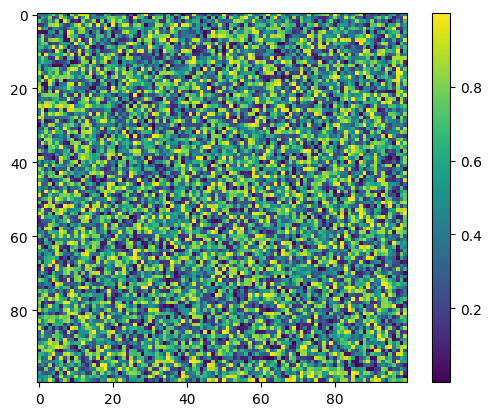

In [6]:
%matplotlib inline

plt.imshow(array)
plt.colorbar()

In [7]:

# Define your input data, tolerance, and fittype
data = array  # Replace with your data
tolerance = 0.1  # Set your tolerance value
fittype = 1  # Set your fittype (1 for median, 2 for bilinear plane)

# Call the quadtree_part function
#indmat, sqval, cx, cy, cntp, nlin = quadtree_regular.quadtree_part(data, tolerance, fittype)



In [46]:
startlevel=3
maxdim=9
tolerance = .5
fittype = 1

lin, col = data.shape

# Adjust data size to be a power of 2
dim = 1
condition = max([lin, col])
while condition > 2 ** dim:
    dim = dim + 1
print(dim)

nlin = 2 ** dim
ncol = nlin

dataexp = np.full((nlin, ncol), np.nan)
dataexp[0:lin, 0:col] = data

# Initialize the quadtree index matrix
indmat = np.array([[1, 0, 10, 0, 0],
                   [2, 0, 10, 0, 0],
                   [3, 0, 10, 0, 0],
                   [4, 0, 10, 0, 0]])



7


In [25]:
def quadtree_level(oldind):
    '''
    Add a new quadtree partitioning level
    '''
    lin, col = oldind.shape
    nlin = 1
    
    # Loop over every old quadtree partition
    for k in range(lin):

        if oldind[k, col - 4] == 1:  # If deeper part isn't needed, we add a 0
            tmp1 = np.concatenate((oldind[k, :col-4], [0])).reshape((1, -1))
            tmp2 = oldind[k, col - 4:].reshape((1, -1))          
            add_indexmatrix = np.column_stack((tmp1, tmp2))

            nlin += 1
        else:  # Deeper partition needed, we add three new lines to the matrix
            tmp1 = np.column_stack((np.tile(oldind[k, :col - 4], (4, 1)), np.array([1, 2, 3, 4])))
            tmp2 = np.column_stack((np.zeros((4, 1)), np.tile(oldind[k, col - 3:], (4, 1))))

            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 4

        if k == 0: 
            indexmatrix = np.empty((0, add_indexmatrix.shape[1]))
            
        indexmatrix = np.vstack((indexmatrix, add_indexmatrix))
        
    return indexmatrix


def check_quadtree(oldindmat, data, tolerance, fittype):
    ilin, icol = oldindmat.shape

    for k in range(ilin):
        if oldindmat[k, icol - 4] == 0:

            chunck = getchunck(oldindmat[k, :], data)

            c1, c2 = np.where((chunck != 0) | (chunck == 0))
            #print(c1.shape,c2.shape)
            chunck = chunck.flatten(order='F')
            nn = np.where(np.isnan(chunck)==False)
            nn = np.array(nn[0]).flatten(order='F')

            chunck_noNaN = chunck[nn]
            c1 = c1[nn] 
            c2 = c2[nn]
            
            if len(chunck_noNaN) >= chunck.size // 2:
                if fittype == 2 and len(chunck_noNaN) >= 3:
                    m, _, rms = fit_bilinplane(chunck_noNaN, np.column_stack((c1, c2)))
                    medvalue = np.median(chunck_noNaN)
                    m = np.array([medvalue, 0, 0])
                elif fittype == 1:
                    medvalue = np.median(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * medvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([medvalue, 0, 0])
                else:
                    meanvalue = np.mean(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * meanvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([meanvalue, 0, 0])

                if rms <= tolerance:
                    oldindmat[k, icol - 4:icol] = np.array([1, *m])
                else:
                    oldindmat[k, icol - 4:icol] = np.array([0, *m])
            elif len(chunck_noNaN) < 1:
                oldindmat[k, icol - 4:icol] = np.array([1, np.nan, np.nan, np.nan])
            else:
                oldindmat[k, icol - 4:icol] = np.array([0, np.nan, np.nan, np.nan])

    newindmat = oldindmat.copy()
    return newindmat

def getchunck(index, data):
    # Get length of real index values, the last three values are
    # to be assigned with the median or something else, the fourth
    # last value is the 'check' signal
    length = len(index) - 4

    # Get size of data
    lin, col = data.shape

    # Get number of lines, or blocksize
    blcksz = lin

    # Initialize
    lst = 1
    cst = 1

    # Loop over every column of the 'real' part of the index matrix
    for k in range(length):
        blcksz = blcksz // 2
        if index[k] == 1:
            lst = lst
            cst = cst
        elif index[k] == 2:
            lst = lst
            cst = cst + blcksz
        elif index[k] == 3:
            lst = lst + blcksz
            cst = cst + blcksz
        elif index[k] == 4:
            lst = lst + blcksz
            cst = cst
    #print(f'cst. =',cst)
    # Pick out the chunk:
    chunk = data[lst-1:lst+blcksz-1, cst-1:cst+blcksz-1]
    return chunk

# Add levels to the index matrix if startlevel is greater than 1
if startlevel > 1:
    for k in range(2, startlevel + 1):
        nindmat = quadtree_level(indmat)
        indmat = nindmat
        


In [26]:
print(indmat.shape)
print(newindmat.shape)

(64, 7)
(9724, 11)


In [27]:
def quadtree_level(oldind):
    '''
    Add a new quadtree partitioning level
    '''
    lin, col = oldind.shape
    nlin = 1
    
    # Loop over every old quadtree partition
    for k in range(lin):

        if oldind[k, col - 4] == 1:  # If deeper part isn't needed, we add a 0
            tmp1 = np.concatenate((oldind[k, :col-4], [0])).reshape((1, -1))
            tmp2 = oldind[k, col - 4:].reshape((1, -1))          
            add_indexmatrix = np.column_stack((tmp1, tmp2))

            nlin += 1
        else:  # Deeper partition needed, we add three new lines to the matrix
            tmp1 = np.column_stack((np.tile(oldind[k, :col - 4], (4, 1)), np.array([1, 2, 3, 4])))
            tmp2 = np.column_stack((np.zeros((4, 1)), np.tile(oldind[k, col - 3:], (4, 1))))

            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 4

        if k == 0: 
            indexmatrix = np.empty((0, add_indexmatrix.shape[1]))
            
        indexmatrix = np.vstack((indexmatrix, add_indexmatrix))
        
    return indexmatrix

# Loop over each k in 2^k
for k in range(startlevel, maxdim + 1):
    newindmat = check_quadtree(indmat, dataexp, tolerance, fittype)
    #print(newindmat.shape)
    che = newindmat[:, -4]
    #print(che)
    # If any zeros in check-column, perform further partitioning
    if np.prod(che) == 0:
        indmat = quadtree_level(newindmat)
    else:
        k = maxdim

print(indmat.shape)

(106, 9)


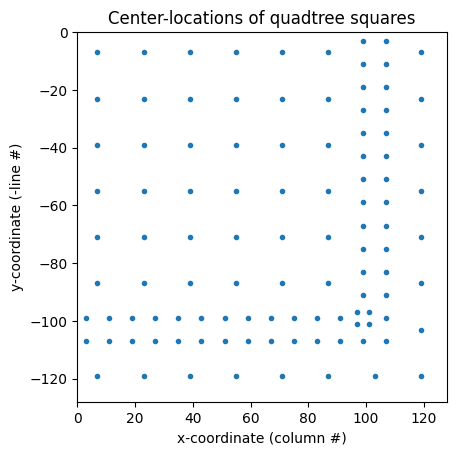

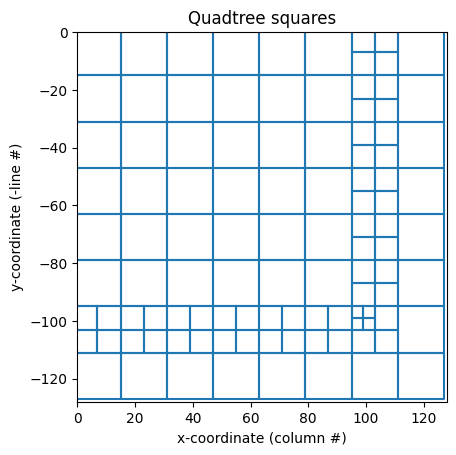

In [28]:
def plot_quadtree(indexmatrix, data):
    coord = []
    coordl = []
    cx = []
    cy = []
    
    lin, col = data.shape
    len_indexmatrix = len(indexmatrix)
    level = len(indexmatrix[0]) - 4
    
    for k in range(len_indexmatrix):
        blcksz = lin
        lst = 0
        cst = 0
        
        for l in range(level):
            if indexmatrix[k, l] != 0:
                blcksz = blcksz / 2
                if indexmatrix[k, l] == 1:
                    lst = lst
                    cst = cst
                elif indexmatrix[k, l] == 2:
                    lst = lst
                    cst = cst + blcksz
                elif indexmatrix[k, l] == 3:
                    lst = lst + blcksz
                    cst = cst + blcksz
                elif indexmatrix[k, l] == 4:
                    lst = lst + blcksz
                    cst = cst
        
        coord.append([lst - 1 + blcksz / 2, cst - 1 + blcksz / 2])
        coordl.append([np.nan, np.nan])
        coordl.append([lst - 1, cst - 1])
        coordl.append([lst - 1, cst - 1 + blcksz])
        coordl.append([lst - 1 + blcksz, cst - 1 + blcksz])
        coordl.append([lst - 1 + blcksz, cst - 1])
        coordl.append([lst - 1, cst - 1])
        
        cx.append([cst - 1, cst - 1 + blcksz, cst - 1 + blcksz, cst - 1])
        cy.append([lst - 1, lst - 1, lst - 1 + blcksz, lst - 1 + blcksz])
    
    coord = np.array(coord)
    coordl = np.array(coordl)
    cx = np.array(cx)
    cy = np.array(cy)
    
    # Plot quadtree partitioning figures
    plt.figure()
    plt.plot(coord[:, 1], -coord[:, 0], '.')
    plt.title('Center-locations of quadtree squares')
    plt.axis('image')
    plt.axis([0, col, -lin, 0])
    plt.xlabel('x-coordinate (column #)')
    plt.ylabel('y-coordinate (-line #)')
    
    plt.figure()
    plt.plot(coordl[:, 1], -coordl[:, 0])
    plt.title('Quadtree squares')
    plt.axis('image')
    plt.axis([0, col, -lin, 0])
    plt.xlabel('x-coordinate (column #)')
    plt.ylabel('y-coordinate (-line #)')
    
    plt.show()
    return coord, coordl, cx, cy

cntp, co2, cx, cy = plot_quadtree(newindmat, dataexp)

(106,)


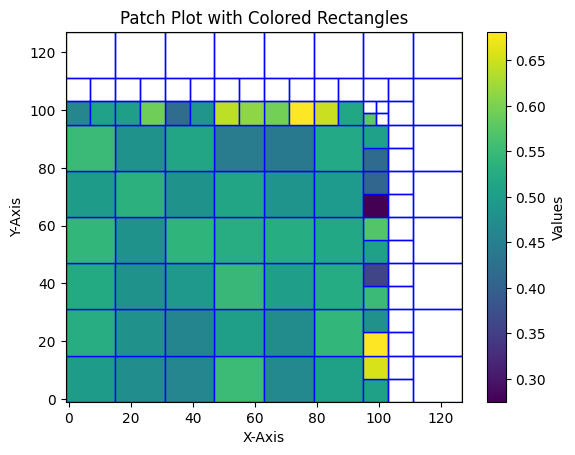

In [41]:
# Plot everything with patches
sqval = newindmat[:, -3]
print(sqval.shape)

def plot_patches(cx,cy,sqval):
    '''
    replicates the patch function of matlab 
    '''
    totalpatches = cx.shape[0]
    
    vertices = np.empty((totalpatches, 4, 2))
    for i in range(totalpatches):  # Loop through each rectangle
        for j in range(4):  # Loop through each vertex of the current rectangle
            x = cx[i,j]
            y = cy[i,j]
            vertices[i, j] = (x, y)
                    
    values = sqval
    
    # Calculate the minimum and maximum values of vertices for axis limits
    x_min = np.min(vertices[:, :, 0])
    x_max = np.max(vertices[:, :, 0])
    y_min = np.min(vertices[:, :, 1])
    y_max = np.max(vertices[:, :, 1])

    # Calculate the minimum and maximum values for colorbar limits
    vmin = np.nanmin(values)
    vmax = np.nanmax(values)
    
    # Create a colormap and normalize values to colors
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = [cmap(norm(value)) for value in values]

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots()

    # Create patches with colors and add them to the axis
    for i, vertex_list in enumerate(vertices):
        polygon = Polygon(vertex_list, closed=True, edgecolor='b', facecolor=colors[i])
        ax.add_patch(polygon)

    # Set axis limits based on min and max of vertices
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Values', ax=ax)

    # Set labels and title
    ax.set_xlabel('X-Axis')
    ax.set_ylabel('Y-Axis')
    ax.set_title('Patch Plot with Colored Rectangles')

    # Display the plot
    plt.show()
    plt.close()
    

plot_patches(cx,cy,sqval)


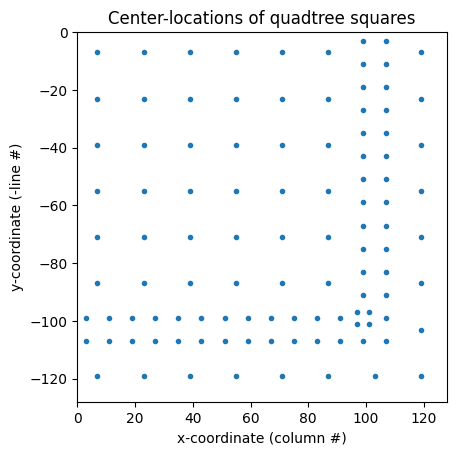

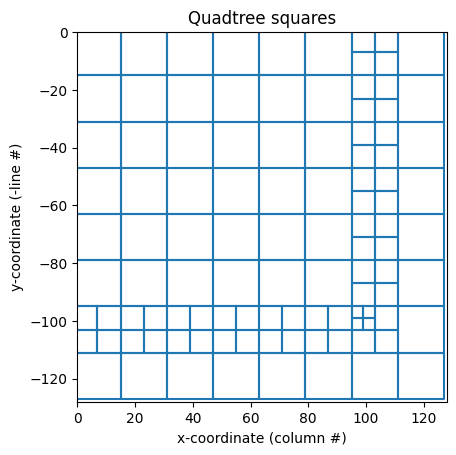

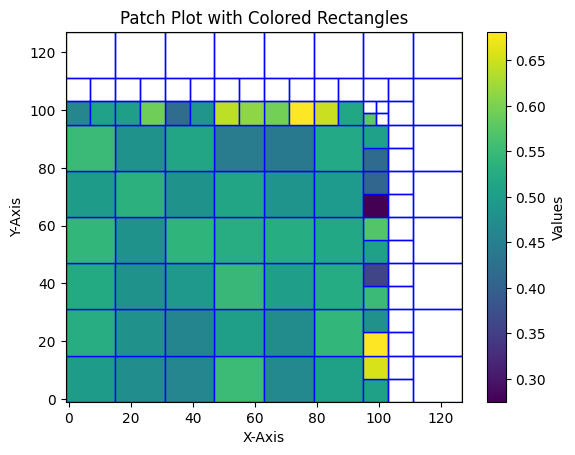

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import copy
from scipy.linalg import inv
from scipy.optimize import curve_fit

# written in matlab by Sigurjon Jonsson 2000 
# converted to python by Rishabh Dutta 2023

def quadtree_level(oldind):
    '''
    Add a new quadtree partitioning level
    '''
    lin, col = oldind.shape
    nlin = 1
    
    # Loop over every old quadtree partition
    for k in range(lin):
        
        if oldind[k, col - 4] == 1:  # If deeper part isn't needed, we add a 0
            tmp1 = np.concatenate((oldind[k, :col-4], [0])).reshape((1, -1))
            tmp2 = oldind[k, col - 4:].reshape((1, -1))          
            
            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 1
        else:  # Deeper partition needed, we add three new lines to the matrix
            tmp1 = np.column_stack((np.tile(oldind[k, :col - 4], (4, 1)), np.array([1, 2, 3, 4])))
            tmp2 = np.column_stack((np.zeros((4, 1)), np.tile(oldind[k, col - 3:], (4, 1))))

            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 4

        if k == 0: 
            indexmatrix = np.empty((0, add_indexmatrix.shape[1]))
            
        indexmatrix = np.vstack((indexmatrix, add_indexmatrix))
        
    return indexmatrix

def fit_bilinplane(data, coord):
    # Clean data and coordinates of NaNs, update coordinate vector accordingly:
    no_nan_ind = np.where(~np.isnan(data))[0]
    d = data[no_nan_ind]
    coord = coord[:, no_nan_ind]

    # Get the number of data points
    N = len(d)

    # If 3 or more data points are left after NaN screening, then
    if N >= 3:
        # Make matrix G
        ones = np.ones(N)
        G = np.vstack((ones, coord[0, :], coord[1, :])).T
        gtginv = inv(np.dot(G.T, G))

        m = np.dot(gtginv, np.dot(G.T, d))

        # Calculate the rms
        rootms = np.sqrt(np.mean((d - np.dot(G, m))**2))
    else:
        rootms = 0
        G = 0
        m = np.array([0, 0, 0])

    return m, G, rootms


def getchunck(index, data):
    # Get length of real index values, the last three values are
    # to be assigned with the median or something else, the fourth
    # last value is the 'check' signal
    length = len(index) - 4
    #print(index)
    # Get size of data
    lin, col = data.shape

    # Get number of lines, or blocksize
    blcksz = lin

    # Initialize
    lst = 1
    cst = 1

    # Loop over every column of the 'real' part of the index matrix
    for k in range(length):
        blcksz = blcksz // 2
        if index[k] == 1:
            lst = lst
            cst = cst
        elif index[k] == 2:
            lst = lst
            cst = cst + blcksz
        elif index[k] == 3:
            lst = lst + blcksz
            cst = cst + blcksz
        elif index[k] == 4:
            lst = lst + blcksz
            cst = cst
    #print(f'cst. =',cst)
    # Pick out the chunk:
    chunk = data[lst-1:lst+blcksz-1, cst-1:cst+blcksz-1]
    return chunk

def plot_quadtree(indexmatrix, data):
    coord = []
    coordl = []
    cx = []
    cy = []
    
    lin, col = data.shape
    len_indexmatrix = len(indexmatrix)
    level = len(indexmatrix[0]) - 4
    
    for k in range(len_indexmatrix):
        blcksz = lin
        lst = 0
        cst = 0
        
        for l in range(level):
            if indexmatrix[k, l] != 0:
                blcksz = blcksz / 2
                if indexmatrix[k, l] == 1:
                    lst = lst
                    cst = cst
                elif indexmatrix[k, l] == 2:
                    lst = lst
                    cst = cst + blcksz
                elif indexmatrix[k, l] == 3:
                    lst = lst + blcksz
                    cst = cst + blcksz
                elif indexmatrix[k, l] == 4:
                    lst = lst + blcksz
                    cst = cst
        
        coord.append([lst - 1 + blcksz / 2, cst - 1 + blcksz / 2])
        coordl.append([np.nan, np.nan])
        coordl.append([lst - 1, cst - 1])
        coordl.append([lst - 1, cst - 1 + blcksz])
        coordl.append([lst - 1 + blcksz, cst - 1 + blcksz])
        coordl.append([lst - 1 + blcksz, cst - 1])
        coordl.append([lst - 1, cst - 1])
        
        cx.append([cst - 1, cst - 1 + blcksz, cst - 1 + blcksz, cst - 1])
        cy.append([lst - 1, lst - 1, lst - 1 + blcksz, lst - 1 + blcksz])
    
    coord = np.array(coord)
    coordl = np.array(coordl)
    cx = np.array(cx)
    cy = np.array(cy)
    
    # Plot quadtree partitioning figures
    plt.figure()
    plt.plot(coord[:, 1], -coord[:, 0], '.')
    plt.title('Center-locations of quadtree squares')
    plt.axis('image')
    plt.axis([0, col, -lin, 0])
    plt.xlabel('x-coordinate (column #)')
    plt.ylabel('y-coordinate (-line #)')
    
    plt.figure()
    plt.plot(coordl[:, 1], -coordl[:, 0])
    plt.title('Quadtree squares')
    plt.axis('image')
    plt.axis([0, col, -lin, 0])
    plt.xlabel('x-coordinate (column #)')
    plt.ylabel('y-coordinate (-line #)')
    
    plt.show()
    return coord, coordl, cx, cy
    
# Example usage:
# Replace 'indexmatrix' and 'data' with your data
# plot_quadtree(indexmatrix, data)

def check_quadtree(oldindmat, data, tolerance, fittype):
    ilin, icol = oldindmat.shape

    for k in range(ilin):
        if oldindmat[k, icol - 4] == 0:

            chunck = getchunck(oldindmat[k, :], data)

            c1, c2 = np.where((chunck != 0) | (chunck == 0))
            #print(c1.shape,c2.shape)
            chunck = chunck.flatten(order='F')
            nn = np.where(np.isnan(chunck)==False)
            nn = np.array(nn[0]).flatten(order='F')

            chunck_noNaN = chunck[nn]
            c1 = c1[nn] 
            c2 = c2[nn]
            #print(chunck.size//2)
            if len(chunck_noNaN) >= chunck.size // 2:
                if fittype == 2 and len(chunck_noNaN) >= 3:
                    m, _, rms = fit_bilinplane(chunck_noNaN, np.column_stack((c1, c2)))
                    medvalue = np.median(chunck_noNaN)
                    m = np.array([medvalue, 0, 0])
                elif fittype == 1:
                    medvalue = np.median(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * medvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([medvalue, 0, 0])
                else:
                    meanvalue = np.mean(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * meanvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([meanvalue, 0, 0])

                if rms <= tolerance:
                    oldindmat[k, icol - 4:icol] = np.array([1, *m])
                else:
                    oldindmat[k, icol - 4:icol] = np.array([0, *m])
            elif len(chunck_noNaN) < 1:
                oldindmat[k, icol - 4:icol] = np.array([1, np.nan, np.nan, np.nan])
            else:
                oldindmat[k, icol - 4:icol] = np.array([0, np.nan, np.nan, np.nan])

    newindmat = oldindmat.copy()
    return newindmat

def plot_patches(cx,cy,sqval):
    '''
    replicates the patch function of matlab 
    '''
    totalpatches = cx.shape[0]
    
    vertices = np.empty((totalpatches, 4, 2))
    for i in range(totalpatches):  # Loop through each rectangle
        for j in range(4):  # Loop through each vertex of the current rectangle
            x = cx[i,j]
            y = cy[i,j]
            vertices[i, j] = (x, y)
                    
    values = sqval
    
    # Calculate the minimum and maximum values of vertices for axis limits
    x_min = np.min(vertices[:, :, 0])
    x_max = np.max(vertices[:, :, 0])
    y_min = np.min(vertices[:, :, 1])
    y_max = np.max(vertices[:, :, 1])

    # Calculate the minimum and maximum values for colorbar limits
    vmin = np.nanmin(values)
    vmax = np.nanmax(values)
    
    # Create a colormap and normalize values to colors
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = [cmap(norm(value)) for value in values]

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots()

    # Create patches with colors and add them to the axis
    for i, vertex_list in enumerate(vertices):
        polygon = Polygon(vertex_list, closed=True, edgecolor='b', facecolor=colors[i])
        ax.add_patch(polygon)

    # Set axis limits based on min and max of vertices
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Values', ax=ax)

    # Set labels and title
    ax.set_xlabel('X-Axis')
    ax.set_ylabel('Y-Axis')
    ax.set_title('Patch Plot with Colored Rectangles')

    # Display the plot
    plt.show()
    plt.close()

def quadtree_part(data, tolerance, fittype, startlevel=1, maxdim=13):
    # Get size of data-file
    lin, col = data.shape

    # Adjust data size to be a power of 2
    dim = 1
    condition = max([lin, col])
    while condition > 2 ** dim:
        dim = dim + 1
    #print(dim)
    
    nlin = 2 ** dim
    ncol = nlin

    dataexp = np.full((nlin, ncol), np.nan)
    dataexp[0:lin, 0:col] = data

    # Initialize the quadtree index matrix
    indmat = np.array([[1, 0, 10, 0, 0],
                       [2, 0, 10, 0, 0],
                       [3, 0, 10, 0, 0],
                       [4, 0, 10, 0, 0]])

    # Add levels to the index matrix if startlevel is greater than 1
    if startlevel > 1:
        for k in range(2, startlevel + 1):
            nindmat = quadtree_level(indmat)
            indmat = nindmat
            
    # Loop over each k in 2^k
    for k in range(startlevel, maxdim + 1):
        newindmat = check_quadtree(indmat, dataexp, tolerance, fittype)
        che = newindmat[:, -4]

        # If any zeros in check-column, perform further partitioning
        if np.prod(che) == 0:
            indmat = quadtree_level(newindmat)
        else:
            k = maxdim

    # Plot the quadtree points and squares
    cntp, co2, cx, cy = plot_quadtree(newindmat, dataexp)

    # Plot everything with patches
    sqval = newindmat[:, -3]
    plot_patches(cx,cy,sqval)

    return newindmat, sqval, cx, cy, cntp, nlin


indmat, sqval, cx, cy, cntp, matsize = quadtree_part(data,tolerance,fittype,startlevel,maxdim)

(array([ 1.,  0.,  1.,  3.,  8., 24., 14.,  4.,  1.,  5.]),
 array([0.27491748, 0.31553339, 0.35614931, 0.39676522, 0.43738113,
        0.47799705, 0.51861296, 0.55922887, 0.59984479, 0.6404607 ,
        0.68107661]),
 <BarContainer object of 10 artists>)

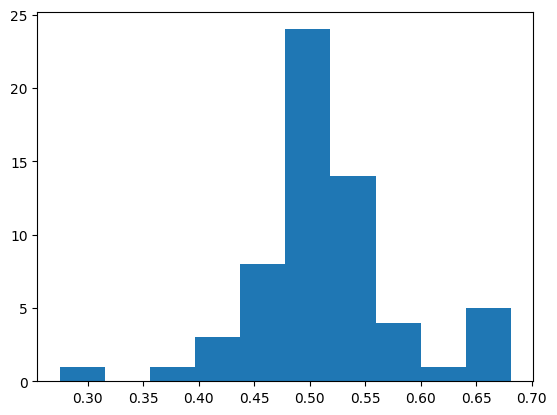

In [71]:
plt.hist(sqval)

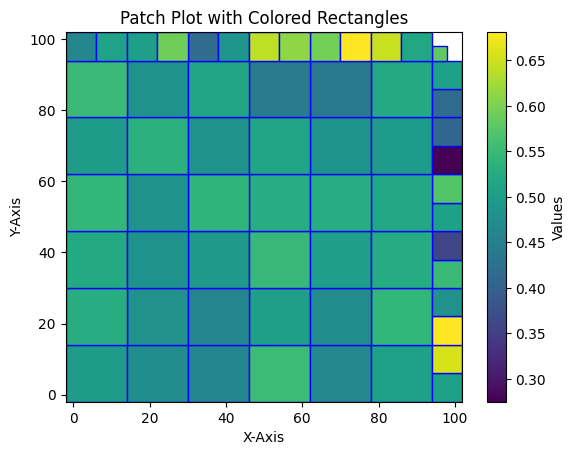

In [76]:
xvals = np.arange(0,data.shape[1])
yvals = np.arange(0,data.shape[0])

ce = cx 
cn = cy 

cnt = cntp[:, [1, 0]].T

try:
    x0 = yvals[0] 
    m1 = yvals[1] - yvals[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals[0]
    m2 = xvals[1] - xvals[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1
    
except: 
    yvals_1d = np.nanmean(yvals,1)
    xvals_1d = np.nanmean(xvals,0)
    
    x0 = yvals_1d[0] 
    m1 = yvals_1d[1] - yvals_1d[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals_1d[0]
    m2 = xvals_1d[1] - xvals_1d[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1

ii = np.where(np.isnan(sqval) == False)
ii = ii[0]

if len(ii) < len(sqval):
    sqval = sqval[ii]
    ce = ce[ii,:]
    cn = cn[ii,:]
    cnt = cnt[:,ii]
    
    indmat = indmat[ii,:]
    
plot_patches(ce,cn,sqval)

(106, 4)


In [114]:
np.arange(startlevel, maxdim + 1)

array([3, 4, 5, 6, 7, 8, 9])

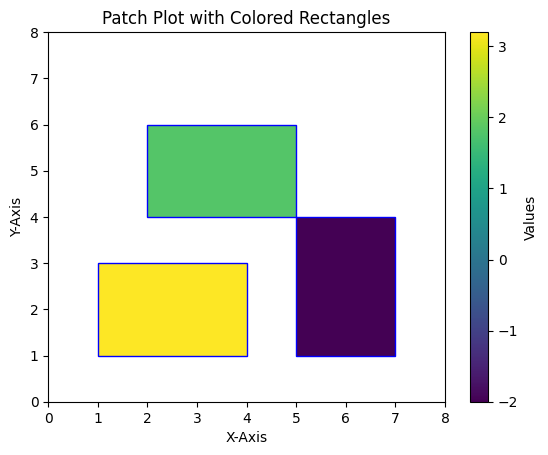

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import numpy as np

# Define vertices as NumPy arrays
vertices = np.array([
    np.array([(1, 1), (4, 1), (4, 3), (1, 3)]),  # Rectangle 1
    np.array([(2, 4), (5, 4), (5, 6), (2, 6)]),   # Rectangle 2
    np.array([(5, 1), (7, 1), (7, 4), (5, 4)])    # Rectangle 3
])

# Define values as a NumPy array
values = np.array([3.2, 1.8, -2])

# Create a colormap and normalize values to colors
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=min(values), vmax=max(values))
colors = [cmap(norm(value)) for value in values]

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Create patches with colors and add them to the axis
for i, vertex_list in enumerate(vertices):
    polygon = Polygon(vertex_list, closed=True, edgecolor='b', facecolor=colors[i])
    ax.add_patch(polygon)

# Set axis limits
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Values')

# Set labels and title
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title('Patch Plot with Colored Rectangles')

# Display the plot
plt.show()

In [53]:
try:
    # Code that may raise an exception
    x = 10 / 0  # This will raise a ZeroDivisionError
except ZeroDivisionError as e:
    # Code to handle the exception
    print(f"Error: {e}")
else:
    # Code to execute if no exception is raised
    result = x + 5
    print(f"Result: {result}")
finally:
    # Code that always runs, whether there was an exception or not
    print("Finally block executed.")
    


Error: division by zero
Finally block executed.


NameError: name 'result' is not defined

In [55]:
xvals, yvals = np.meshgrid(np.arange(0,data.shape[1]),np.arange(0,data.shape[0]))

try:
    x0 = yvals[0] 
    m1 = yvals[1] - yvals[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals[0]
    m2 = xvals[1] - xvals[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1
    
except: 
    yvals_1d = np.nanmean(yvals,1)
    xvals_1d = np.nanmean(xvals,0)
    
    x0 = yvals_1d[0] 
    m1 = yvals_1d[1] - yvals_1d[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals_1d[0]
    m2 = xvals_1d[1] - xvals_1d[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1


print(ce)

[[ -2.  14.  14.  -2.]
 [ 14.  30.  30.  14.]
 [ 14.  30.  30.  14.]
 [ -2.  14.  14.  -2.]
 [ 30.  46.  46.  30.]
 [ 46.  62.  62.  46.]
 [ 46.  62.  62.  46.]
 [ 30.  46.  46.  30.]
 [ 30.  46.  46.  30.]
 [ 46.  62.  62.  46.]
 [ 46.  62.  62.  46.]
 [ 30.  46.  46.  30.]
 [ -2.  14.  14.  -2.]
 [ 14.  30.  30.  14.]
 [ 14.  30.  30.  14.]
 [ -2.  14.  14.  -2.]
 [ 62.  78.  78.  62.]
 [ 78.  94.  94.  78.]
 [ 78.  94.  94.  78.]
 [ 62.  78.  78.  62.]
 [ 94. 102. 102.  94.]
 [102. 110. 110. 102.]
 [102. 110. 110. 102.]
 [ 94. 102. 102.  94.]
 [110. 126. 126. 110.]
 [110. 126. 126. 110.]
 [ 94. 102. 102.  94.]
 [102. 110. 110. 102.]
 [102. 110. 110. 102.]
 [ 94. 102. 102.  94.]
 [ 94. 102. 102.  94.]
 [102. 110. 110. 102.]
 [102. 110. 110. 102.]
 [ 94. 102. 102.  94.]
 [110. 126. 126. 110.]
 [110. 126. 126. 110.]
 [ 94. 102. 102.  94.]
 [102. 110. 110. 102.]
 [102. 110. 110. 102.]
 [ 94. 102. 102.  94.]
 [ 62.  78.  78.  62.]
 [ 78.  94.  94.  78.]
 [ 78.  94.  94.  78.]
 [ 62.  78.

In [56]:
xvals = np.arange(0,data.shape[1])
yvals = np.arange(0,data.shape[0])

try:
    x0 = yvals[0] 
    m1 = yvals[1] - yvals[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals[0]
    m2 = xvals[1] - xvals[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1
    
except: 
    yvals_1d = np.nanmean(yvals,1)
    xvals_1d = np.nanmean(xvals,0)
    
    x0 = yvals_1d[0] 
    m1 = yvals_1d[1] - yvals_1d[0]
    cn = (cn -1)*m1 + x0 
    cnt[1,:] = (cnt[1,:] - 1)*m1 +x0 

    x1 = xvals_1d[0]
    m2 = xvals_1d[1] - xvals_1d[0]
    ce = (ce-1)*m2 + x1
    cnt[0,:] = (cnt[0,:] -1)*m2 + x1


print(ce)

[[ -3.  13.  13.  -3.]
 [ 13.  29.  29.  13.]
 [ 13.  29.  29.  13.]
 [ -3.  13.  13.  -3.]
 [ 29.  45.  45.  29.]
 [ 45.  61.  61.  45.]
 [ 45.  61.  61.  45.]
 [ 29.  45.  45.  29.]
 [ 29.  45.  45.  29.]
 [ 45.  61.  61.  45.]
 [ 45.  61.  61.  45.]
 [ 29.  45.  45.  29.]
 [ -3.  13.  13.  -3.]
 [ 13.  29.  29.  13.]
 [ 13.  29.  29.  13.]
 [ -3.  13.  13.  -3.]
 [ 61.  77.  77.  61.]
 [ 77.  93.  93.  77.]
 [ 77.  93.  93.  77.]
 [ 61.  77.  77.  61.]
 [ 93. 101. 101.  93.]
 [101. 109. 109. 101.]
 [101. 109. 109. 101.]
 [ 93. 101. 101.  93.]
 [109. 125. 125. 109.]
 [109. 125. 125. 109.]
 [ 93. 101. 101.  93.]
 [101. 109. 109. 101.]
 [101. 109. 109. 101.]
 [ 93. 101. 101.  93.]
 [ 93. 101. 101.  93.]
 [101. 109. 109. 101.]
 [101. 109. 109. 101.]
 [ 93. 101. 101.  93.]
 [109. 125. 125. 109.]
 [109. 125. 125. 109.]
 [ 93. 101. 101.  93.]
 [101. 109. 109. 101.]
 [101. 109. 109. 101.]
 [ 93. 101. 101.  93.]
 [ 61.  77.  77.  61.]
 [ 77.  93.  93.  77.]
 [ 77.  93.  93.  77.]
 [ 61.  77.

In [52]:
x = 10/0

ZeroDivisionError: division by zero